In [32]:
from __future__ import print_function
from __future__ import division
from collections import defaultdict, OrderedDict
import calendar
import datetime
import dateutil.parser as dparser
from glob import glob
import logging
import matplotlib.pyplot as plt
import matplotlib.path as mplpath
from matplotlib_scalebar.scalebar import ScaleBar
import os
import numpy as np
import pandas as pd
import skimage
import skimage.io as skio
from skimage import draw
import subprocess
import sys
import time
import ujson as json

from optical_vessel_detection.core import img_utils as iutils 
from optical_vessel_detection.core import planet_utils as putils 
from optical_vessel_detection.core.annotation_utils import get_labeled_props

from optical_vessel_detection.support.regions import approximate_simplified_nk_eez
from optical_vessel_detection.support.regions import full_study_area
from optical_vessel_detection.support.regions import reduced_study_area
from optical_vessel_detection.support import notebook_utils
from optical_vessel_detection.support.notebook_utils import path2sceneid, path2datestr
from optical_vessel_detection.support.info import fully_annotated, aois_by_date
from optical_vessel_detection.support import counting_tools
%matplotlib inline

proj_id = os.environ['PROJ_ID']

## Process / Load Info

In [33]:
scene_map = notebook_utils.create_scene_map(
    f'{proj_id}.machine_learning_production.planet_scene_info')

detections_map = notebook_utils.create_detections_map(
    f'{proj_id}.machine_learning_production.detected_pair_trawlers_1_1_aug')

annotated_paths = (
    glob("../../../../image-vessel-identification/data/paper/aoi_annotations_rnd1/*.png")           
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd2/*.tif')
  + glob('../../../../image-vessel-identification/data/paper/aoi_annotations_rnd3/*.tif')
      )

annotations_map = notebook_utils.create_annotations_map(annotated_paths, 
                                            'gs://machine-learning-production/planet_images/nk_detection/',
                                            f'{proj_id}:machine_learning_dev_ttl_120d.annotations')

Downloading: 100%|██████████| 8987/8987 [00:01<00:00, 6293.73rows/s]


20170627
20170806
20171024
20180514
20180602
20180715
20180731
20180826
20180911
20180917
20180929
Skipping 20180929_010750_104e
20181008
Skipping 20181008_013024_1008
Skipping 20181008_013026_1008
20181102
WARNING 20171024_011827_100c has 2 timestamps
WARNING 20171024_011700_0f18 has 2 timestamps
WARNING 20171024_011546_1009 has 2 timestamps
WARNING 20171024_011505_1010 has 2 timestamps
WARNING 20171024_012048_0f35 has 2 timestamps
WARNING 20171024_015829_1020 has 2 timestamps
WARNING 20171024_012158_101f has 2 timestamps
WARNING 20171024_012043_0f35 has 2 timestamps
WARNING 20171024_011652_0f18 has 2 timestamps
WARNING 20171024_012147_101f has 2 timestamps
WARNING 20171024_011500_1010 has 2 timestamps
WARNING 20171024_011504_1010 has 2 timestamps
WARNING 20171024_015844_1020 has 2 timestamps
WARNING 20171024_012155_101f has 2 timestamps
WARNING 20171024_012623_0e20 has 2 timestamps
WARNING 20171024_011538_1009 has 2 timestamps
WARNING 20171024_012052_0f35 has 2 timestamps
WARNING 201

WARNING 20180715_012244_0f32 has 2 timestamps
WARNING 20180715_012049_0f36 has 2 timestamps
WARNING 20180715_012051_0f36 has 2 timestamps
WARNING 20180715_012254_0f32 has 2 timestamps
WARNING 20180715_012055_0f36 has 2 timestamps
WARNING 20180715_012050_0f36 has 2 timestamps
WARNING 20180715_012248_0f32 has 2 timestamps
WARNING 20180715_012054_0f36 has 2 timestamps
WARNING 20180731_011814_0f2b has 2 timestamps
WARNING 20180731_011831_1040 has 2 timestamps
WARNING 20180731_011313_0f2d has 2 timestamps
WARNING 20180731_011321_0f2d has 2 timestamps
WARNING 20180731_011041_1053 has 2 timestamps
WARNING 20180731_011043_1053 has 2 timestamps
WARNING 20180731_011046_1053 has 2 timestamps
WARNING 20180731_011045_1053 has 2 timestamps
WARNING 20180731_011044_1053 has 2 timestamps
WARNING 20180731_011803_0f2b has 2 timestamps
WARNING 20180826_012519_103d has 2 timestamps
WARNING 20180826_012413_103b has 2 timestamps
WARNING 20180826_011253_0f44 has 2 timestamps
WARNING 20180826_012420_103b has 2

WARNING 20181008_010855_1053 has 2 timestamps
WARNING 20181008_012528_1014 has 2 timestamps
WARNING 20181008_012619_1035 has 2 timestamps
WARNING 20181008_012422_0f12 has 2 timestamps
WARNING 20181008_010330_1_1050 has 2 timestamps
WARNING 20181008_010609_1052 has 2 timestamps
WARNING 20181008_012918_0f22 has 2 timestamps
WARNING 20181008_012622_1035 has 2 timestamps
WARNING 20181008_010858_1053 has 2 timestamps
WARNING 20181008_010607_1052 has 2 timestamps
WARNING 20181008_012526_1014 has 2 timestamps
WARNING 20181008_010602_1_1052 has 2 timestamps
WARNING 20181008_010852_1053 has 2 timestamps
WARNING 20181008_012541_1014 has 2 timestamps
WARNING 20181008_012617_1035 has 2 timestamps
WARNING 20181008_012424_0f12 has 2 timestamps
WARNING 20181008_012911_0f22 has 2 timestamps
WARNING 20181008_010611_1052 has 2 timestamps
WARNING 20181102_010102_0f4b has 2 timestamps
WARNING 20181102_005823_0f2d has 2 timestamps
WARNING 20181102_012645_0f42 has 2 timestamps
WARNING 20181102_005824_1_0f2d

## Number of Annotated Scenes

In [34]:
print("Annotated paths exluding bad scenes", 
     len([x for x in annotated_paths if path2sceneid(x) not in notebook_utils.BAD_SCENES]))
all_annotations = pd.concat(annotations_map.values())
print("Total pairs", (all_annotations.kind == "pair_trawlers").sum())
print("Total singles", (all_annotations.kind == "single_trawler").sum())
print("Total other", (all_annotations.kind == "other_boat").sum())

Annotated paths exluding bad scenes 587
Total pairs 2566
Total singles 936
Total other 603


## Plot Detections on Selected Days

The plot code also determines scenes in AOIs and counts 
trawlers. 

In [35]:
# Dates that were run for false postive evaluation, but were not
# included in final outputs because they had insuffient coverage
# and were near other dates.
skip_dates = ['20180917', '20180929']

def plot_dates(dates, scene_legend_offset):
    n = len(dates)
    scenes_to_classify = {}
    study_area_counts = {}
    annotated_scenes_to_classify = {} # TODO: rename this and above
    fig, axes = plt.subplots((n + 3) // 4, 4, figsize=(12, 2.5 * ((n + 3) // 4)))
    axes = axes.reshape(-1, 4)
    for i, date in enumerate(sorted(dates)):
        is_last = (i == len(dates) - 1)
        show_x = i + 4 >= n
        show_y = i % 4 == 0
        ax = axes[i // 4, i % 4]
        aois = aois_by_date.get(date, [])
        scenes_to_classify[date] = counting_tools.plot_date(date, detections_map, scene_map, ax, aois=aois, 
                                             show_scalebar=is_last, show_legend=is_last,
                                            valid_area=reduced_study_area, 
                                             show_xticks=show_x, show_yticks=show_y,
                                             scene_legend_offset=scene_legend_offset,
                                            detection_legend_size=4)
        #
        df = detections_map[date]
        valid_mask = counting_tools.create_valid_area_mask(df.longitude, df.latitude, reduced_study_area)
        scene_counts = counting_tools.create_scene_counts(df, scene_map)
        aoi_pts, aoi_pairs = counting_tools.compute_detection_counts(
                df.kind, valid_mask, valid_mask, scene_counts)
        study_area_counts[date] = (aoi_pts, aoi_pairs)
        if date in fully_annotated:
            df = annotations_map[date]
            valid_mask = counting_tools.create_valid_area_mask(df.longitude, df.latitude, reduced_study_area)
            aoi_mask = counting_tools.create_aoi_mask(df, aois)
            scene_counts = counting_tools.create_scene_counts(df, scene_map)
            aoi_pts, aoi_pairs = counting_tools.compute_detection_counts(
                                        df.kind, valid_mask, aoi_mask, scene_counts)
            annotated_scenes_to_classify[date] = (aoi_pts, aoi_pairs)

    for j in range(i+1, 4 * len(axes)):
        ax = axes[j // 4, j % 4]
        ax.axis('off')
    plt.tight_layout()
    return scenes_to_classify, annotated_scenes_to_classify, study_area_counts

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

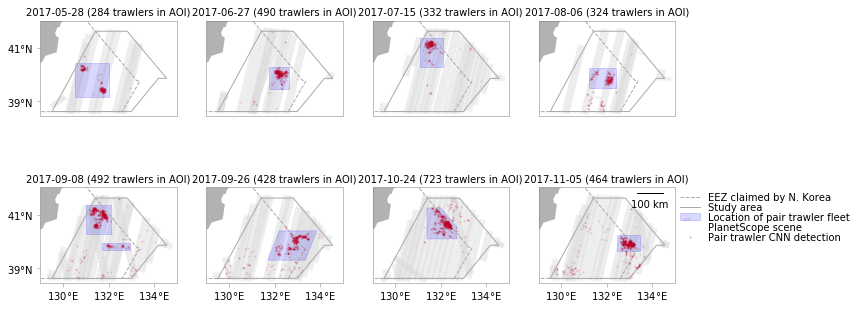

In [36]:
dates_2017 = [x for x in detections_map if  x.startswith('2017') and x not in skip_dates]
detect_info_2017, annot_info_2017, study_area_counts_2017 = plot_dates(dates_2017, (135.51, 40.82))

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


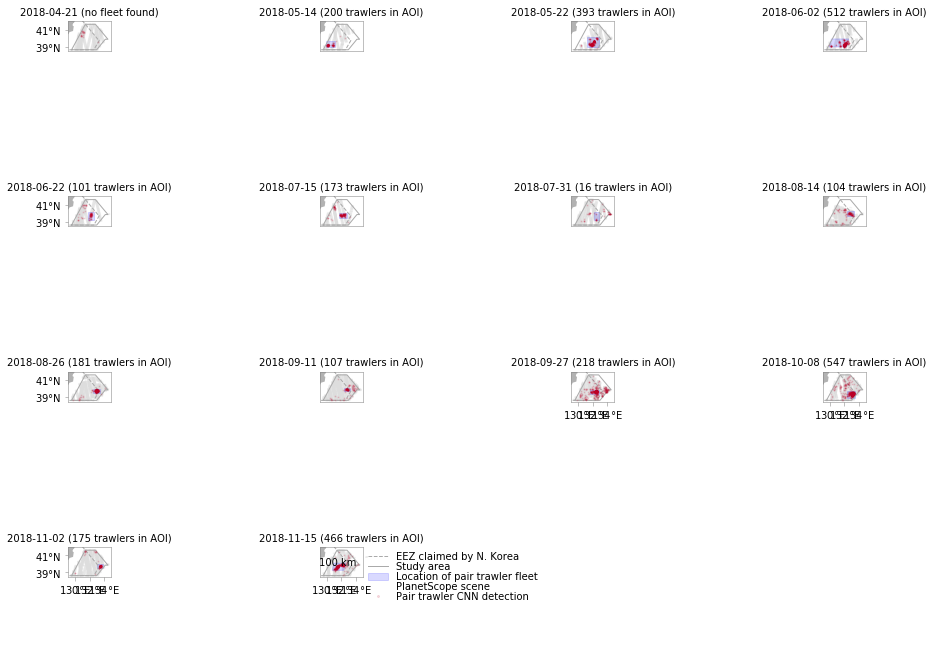

In [37]:
dates_2018 = sorted([x for x in detections_map if x.startswith('2018') and x not in skip_dates])
detect_info_2018, annot_info_2018, study_area_counts_2018 = plot_dates(dates_2018, (135.51, 40.82))

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda

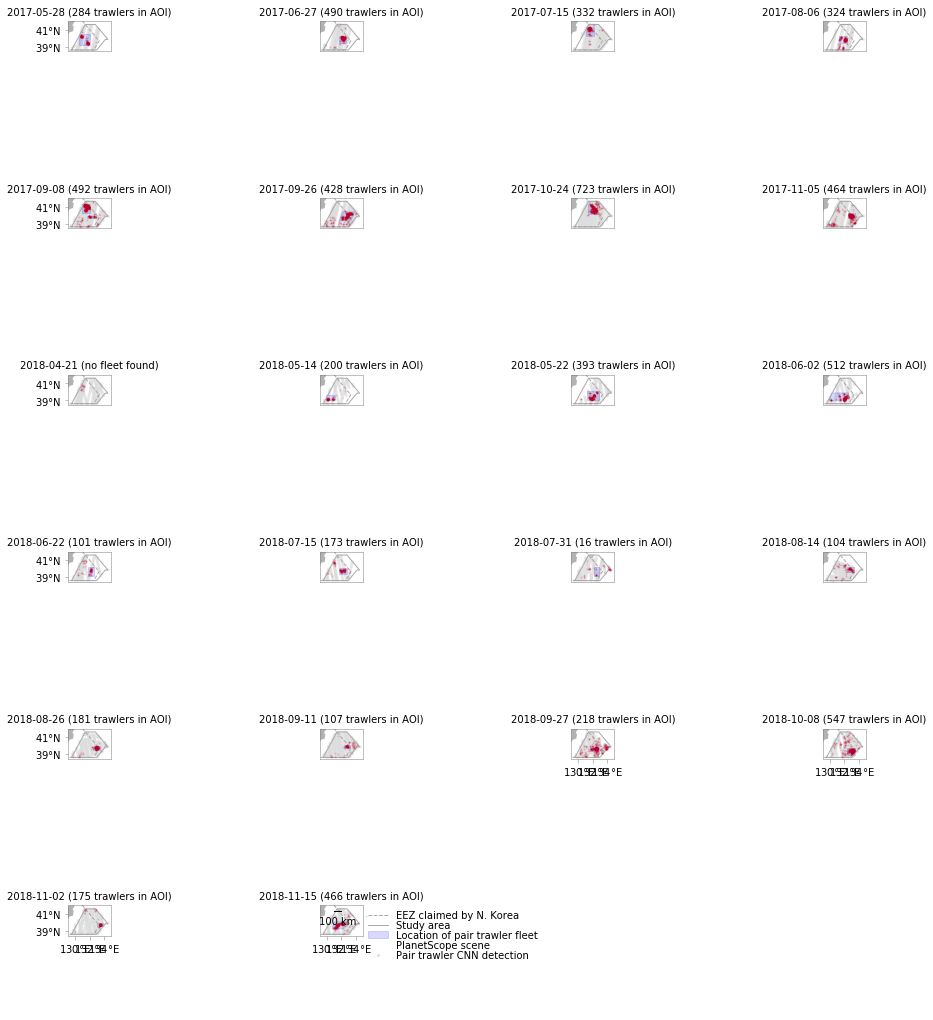

In [38]:
_ = plot_dates(dates_2017 + dates_2018, (135.51, 40.72))
plt.savefig('/Users/timothyhochberg/Desktop/detections.png', dpi=300)

### Compare Different Kinds of Clusters

In [39]:
# import imp, source.regions; imp.reload(notebook_utils); imp.reload(source.regions); imp.reload(counting_tools)

/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "
/Users/timothyhochberg/anaconda3/envs/daytime-optical-imagery/lib/python3.7/site-packages/pandas/core/computation/expressions.py:178: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  f"evaluating in Python space because the {repr(op_str)} "


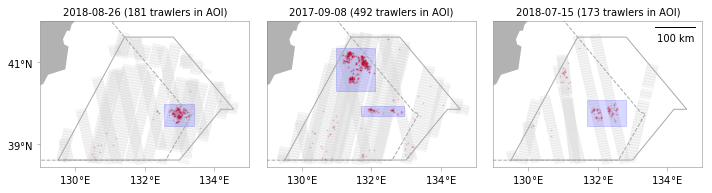

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
date = '20180826'
_ = counting_tools.plot_date(date, detections_map, scene_map, ax1, aois=aois_by_date[date], 
                     show_legend=False, show_scalebar=False,  valid_area=reduced_study_area)
date = '20170908'
_ = counting_tools.plot_date(date, detections_map, scene_map, ax2, aois=aois_by_date[date], 
                     show_legend=False, show_scalebar=False, valid_area=reduced_study_area, show_yticks=False)
date = '20180715'
_ = counting_tools.plot_date(date, detections_map, scene_map, ax3, aois=aois_by_date[date], 
             valid_area=reduced_study_area, show_yticks=False, show_legend=False)
plt.tight_layout()
plt.savefig('/Users/timothyhochberg/Desktop/compare_detection.png', dpi=300)

## Plot Counts Over Time

In [41]:
def plot_counts_over_time(scenes_to_classify, annotated_scenes_to_classify, year,
                         show_xticks=True, legend_loc=1, label=None):
    count_dates = []
    counts = []
    ann_dates = []
    ann_counts = []
    ann_pairs = []
    for datestr in sorted(scenes_to_classify):
        pts, pairs = scenes_to_classify[datestr]
        date = dparser.parse(datestr)
        count_dates.append(date.timetuple().tm_yday)
        counts.append(pts)
        det_pts = pts
        if datestr in annotated_scenes_to_classify:
            pts, pairs = annotated_scenes_to_classify[datestr]
            ann_dates.append(date.timetuple().tm_yday)
            ann_counts.append(pts)
            ann_pairs.append(2 * pairs)
    plt.figure(figsize=(12, 8))
    plt.plot(count_dates, counts, 'ok', label='model')
    plt.plot(count_dates, counts, ':k')
    plt.plot(ann_dates, ann_pairs, '+r', label='human annotators', markersize=15)
#     plt.plot(ann_dates, ann_counts, 'xr', label='human -- total', markersize=15)
    ticks = []
    labels = []
    for month in range(4, 13):
        # Year doesn't really matter
        date = datetime.datetime(2017, month, 1)
        ticks.append(date.timetuple().tm_yday)
        labels.append(calendar.month_name[month])
    plt.legend(loc=legend_loc, fontsize=16)

    plt.ylabel('pair trawlers counted', fontsize=16)
    plt.title('Model and Human Pair Trawler Counts for {}'.format(year), fontsize=14)
    plt.ylim(0, None)
    plt.xlim(ticks[0], ticks[-1])
    if show_xticks:
        plt.xticks(ticks, labels, rotation='vertical', fontsize=16)
    else:
        plt.xticks([])
    plt.tick_params(axis='both', which='major', labelsize=16)
        
    if label is not None:
        plt.text(0.015, 0.98, label, horizontalalignment='left',
             verticalalignment='top', transform=plt.gca().transAxes,
            fontsize=24)
        
    plt.tight_layout()
    

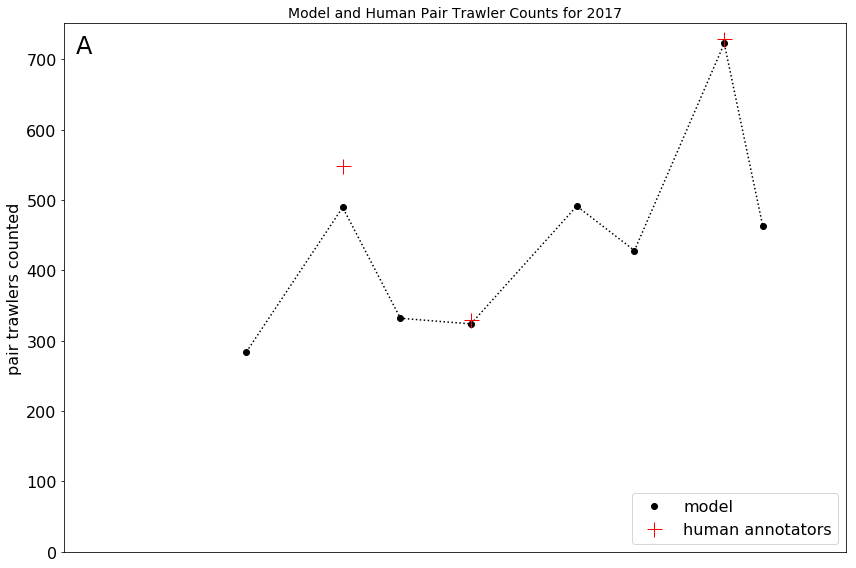

In [42]:
plot_counts_over_time(detect_info_2017, annot_info_2017, 2017, show_xticks=False, legend_loc=4, label="A")
plt.savefig('/Users/timothyhochberg/Desktop/trawler_pairs_comparison_2017.png', dpi=300)

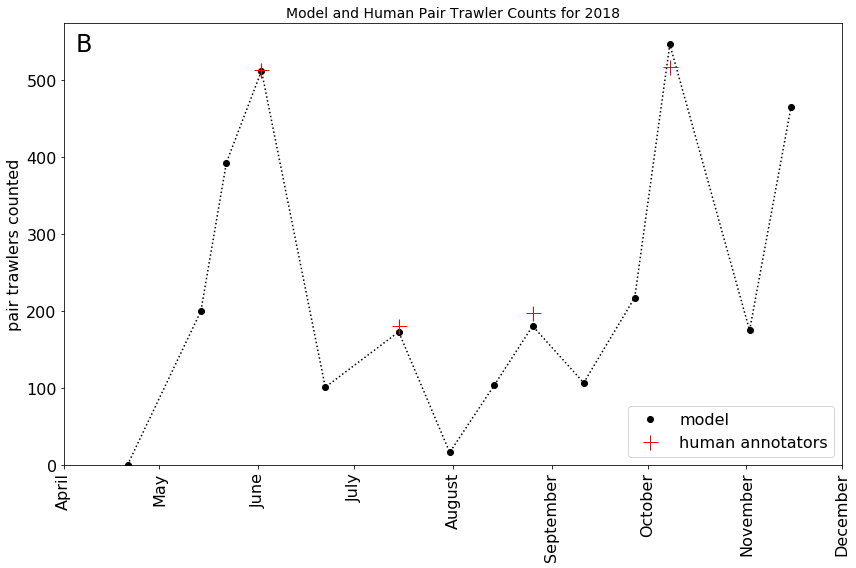

In [43]:
plot_counts_over_time(detect_info_2018, annot_info_2018, 2018, show_xticks=True, legend_loc=4, label='B')
plt.savefig('/Users/timothyhochberg/Desktop/trawler_pairs_comparison_2018.png', dpi=300)

In [44]:
def plot_counts_over_time_2(scenes_to_classify1, annotated_scenes_to_classify1, 
                           scenes_to_classify2, annotated_scenes_to_classify2, 
                         show_xticks=True, legend_loc=1, label=None):
    count_dates = []
    counts = []
    ann_dates = []
    ann_counts = []
    ann_pairs = []
    for year, scenes_to_classify, annotated_scenes_to_classify in [
                (2017, scenes_to_classify1, annotated_scenes_to_classify1),
                (2018, scenes_to_classify2, annotated_scenes_to_classify2)]:
        for datestr in sorted(scenes_to_classify):
            pts, pairs = scenes_to_classify[datestr]
            date = dparser.parse(datestr)
            count_dates.append(date.timetuple().tm_yday + 365 * (year==2018))
            counts.append(pts)
            det_pts = pts
            if datestr in annotated_scenes_to_classify:
                pts, pairs = annotated_scenes_to_classify[datestr]
                ann_dates.append(date.timetuple().tm_yday + 365 * (year==2018))
                ann_counts.append(pts)
                ann_pairs.append(2 * pairs)
    plt.figure(figsize=(16, 8))
    plt.plot(count_dates, counts, 'ok', label='model')
    plt.plot([x for x in count_dates if (x <= 365)], 
             [y for (x, y) in zip(count_dates, counts)  if (x <= 365)], ':k')
    plt.plot([x for x in count_dates if (x > 365)], 
             [y for (x, y) in zip(count_dates, counts)  if (x > 365)], ':k')
    print(counts)
    plt.plot(ann_dates, ann_pairs, '+r', label='human annotators', markersize=15)
    ticks = []
    labels = []
    for year in [2017, 2018]:
        for month in range(1, 13):
            date = datetime.datetime(year, month, 1)
            ticks.append(date.timetuple().tm_yday + 365 * (year == 2018))
            labels.append("{}".format(calendar.month_name[month][:3]))
    plt.legend(loc=legend_loc, fontsize=16)

    plt.ylabel('pair trawlers counted', fontsize=16)
    plt.title('Model and Human Pair Trawler Counts'.format(year), fontsize=14)
    plt.ylim(0, None)
    plt.xlim(ticks[0], ticks[-1])
    if show_xticks:
        plt.xticks(ticks, labels, )#rotation='vertical'
    else:
        plt.xticks([])
    plt.tick_params(axis='both', which='major', labelsize=16)
        
    if label is not None:
        plt.text(0.015, 0.98, label, horizontalalignment='left',
             verticalalignment='top', transform=plt.gca().transAxes,
            fontsize=24)
        
    plt.vlines(365.5, 0, 8000, colors='k', linestyles='--')
        
    plt.text(0.236, -0.08, '2017', horizontalalignment='center',
              verticalalignment='center', transform=plt.gca().transAxes,
            fontsize=16)
        
    plt.text(0.761, -0.08, '2018', horizontalalignment='center',
              verticalalignment='center', transform=plt.gca().transAxes,
            fontsize=16)
    
    plt.tight_layout()
    
    plt.margins(0.2)
    # Tweak spacing to prevent clipping of tick-labels
    plt.subplots_adjust(bottom=0.15)

[284.3, 489.7, 332.0, 324.0, 491.5, 428.3, 722.7, 463.5, 0.0, 200.0, 393.0, 512.3, 101.0, 173.0, 16.3, 103.8, 180.7, 106.7, 217.6, 546.7, 175.0, 465.7]


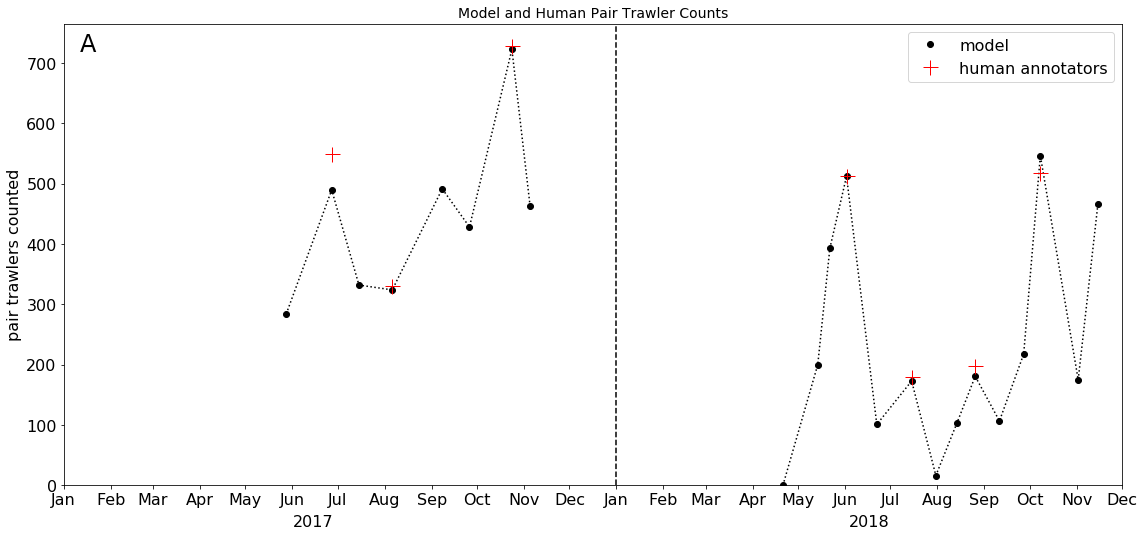

In [45]:
plot_counts_over_time_2(detect_info_2017, annot_info_2017,
                      detect_info_2018, annot_info_2018,
                      show_xticks=True, legend_loc=1, label='A')
plt.savefig('/Users/timothyhochberg/Desktop/trawler_pairs_comparison_2017and2018.png', dpi=300)

## Plot Model vs Human Annotator Counts

* We expect the model and human counts to agree on the first plot
  since that is only counting pair trawlers.
* We expect the model counts to be lower than the human counts on the
  second plot, since the human counts contain both paired and unpaired
  trawlers.

0.9835334977773011 13.01757054358235


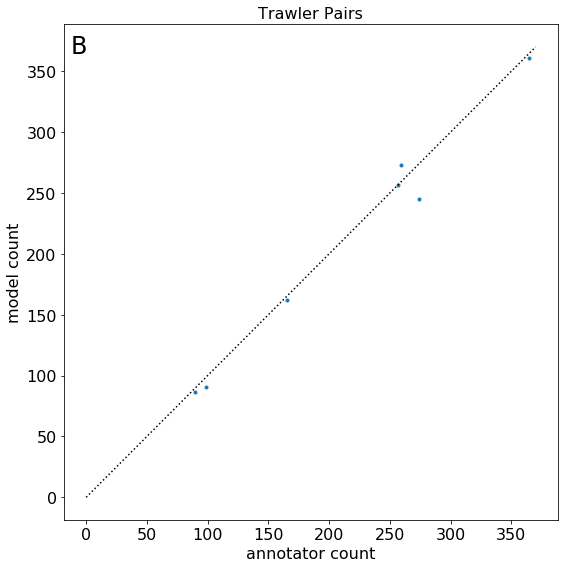

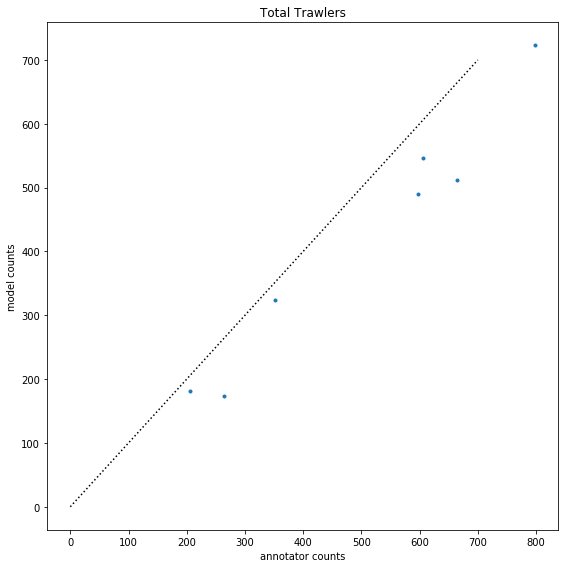

In [46]:
fix, (ax1) = plt.subplots(1, 1, figsize=(8, 8))

all_anot_items = [x for x in sorted(list(annot_info_2017.items()) + list(annot_info_2018.items()))]
dates = [k for (k, v) in all_anot_items]
all_detect_items = sorted(list(detect_info_2017.items()) + list(detect_info_2018.items()))
model = [v[1] for (k, v) in sorted(all_detect_items) if k in dates]
human = [v[1] for (k, v) in sorted(all_anot_items)]
ax1.plot(human, model, '.')
ax1.plot(np.linspace(0, 370), np.linspace(0, 370), 'k:')
ax1.set_xlabel('annotator count', fontsize=16)
ax1.set_ylabel('model count', fontsize=16)
r2 = np.corrcoef(human, model)[0, 1] ** 2
rms = np.sqrt((np.subtract(human, model) ** 2).mean())
print(r2, rms)
# if r2 >= 0.995:
#     ax1.set_title('Trawler Pairs ($R^2$ > 0.99)'.format(r2))
# else:
#     ax1.set_title('Trawler Pairs ($R^2$ = {:.2f})'.format(r2))
ax1.set_title('Trawler Pairs', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)

ax1.text(0.015, 0.98, "B", horizontalalignment='left',
     verticalalignment='top', transform=ax1.transAxes,
    fontsize=24)

plt.tight_layout()
plt.savefig('/Users/timothyhochberg/Desktop/trawler_pairs_comparison.png', dpi=300)

fix, (ax2) = plt.subplots(1, 1, figsize=(8, 8))

model = [v[0] for (k, v) in sorted(all_detect_items) if k in dates]
human = [v[0] for (k, v) in sorted(all_anot_items)]
ax2.plot(human, model, '.')
ax2.plot(np.linspace(0, 700), np.linspace(0, 700), 'k:')
ax2.set_xlabel('annotator counts')
ax2.set_ylabel('model counts')
r2 = np.corrcoef(human, model)[0, 1] ** 2
rms = np.sqrt((np.subtract(human, model) ** 2).mean())
ax2.set_title('Total Trawlers')
plt.tight_layout()

# plt.savefig('/Users/timothyhochberg/Desktop/total_trawlers_comparison.png', dpi=300)

In [47]:
total_count = sum([v[0] for (k, v) in sorted(all_anot_items)])
total_pairs = sum([v[1] for (k, v) in sorted(all_anot_items)])
frac_singles = (total_count - 2 * total_pairs) / total_count
print("Percent single trawlers = {:.2f}".format(frac_singles * 100))

Percent single trawlers = 13.55


In [48]:
kinds = set()
scenes = set()
for date in annotations_map:
    kinds |= set(annotations_map[date].kind)
    scenes |= set(annotations_map[date].scene_id)
    
kind_counts = {}
for kind in kinds:
    n = 0
    n_dates = 0
    for date in sorted(annotations_map):
        if date not in fully_annotated:
            continue
        if date not in set(x[0] for x in all_anot_items):
            print(date)
            print((annotations_map[date].kind == kind).sum())
        n_dates += 1
        n += (annotations_map[date].kind == kind).sum()
    kind_counts[kind] = n
    
total_trawlers = kind_counts['single_trawler'] + 2 * kind_counts['pair_trawlers']
print('n_dates', n_dates)
print('n_scenes', len(scenes))
print()
print('n_trawlers_pairs', kind_counts['pair_trawlers'])
print('n_single_trawlers', kind_counts['single_trawler'])
print('n_other_vessels', kind_counts['other_boat'])

n_dates 7
n_scenes 587

n_trawlers_pairs 2001
n_single_trawlers 712
n_other_vessels 434
